In [69]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import numpy as np
import csv
from tqdm import tqdm

"""Change to the data folder"""
new_path = "./new_train/new_train/"

# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    city = [scene['city'] for scene in batch]
    scene_idx = [scene['scene_idx'] for scene in batch]
    agent_id = [scene['agent_id'] for scene in batch]
    car_mask = [scene['car_mask'] for scene in batch]
    track_id = [scene['track_id'] for scene in batch]
    pin = [scene['p_in'] for scene in batch]
    vin = [scene['v_in'] for scene in batch]
    pout = [scene['p_out'] for scene in batch]
    vout = [scene['v_out'] for scene in batch]
    lane = [scene['lane'] for scene in batch]
    lane_norm = [scene['lane_norm'] for scene in batch]
    
    
    return [city, scene_idx, agent_id, car_mask, track_id, pin, vin, pout, vout, lane, lane_norm]


def my_collate_for_csv(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    city = [scene['city'] for scene in batch]
    scene_idx = [scene['scene_idx'] for scene in batch]
    agent_id = [scene['agent_id'] for scene in batch]
    car_mask = [scene['car_mask'] for scene in batch]
    track_id = [scene['track_id'] for scene in batch]
    pin = [scene['p_in'] for scene in batch]
    vin = [scene['v_in'] for scene in batch]
    lane = [scene['lane'] for scene in batch]
    lane_norm = [scene['lane_norm'] for scene in batch]
    
    
    return [city, scene_idx, agent_id, car_mask, track_id, pin, vin, lane, lane_norm]

def conv_pos_to_disp(x, last_known=None, use_known = False):
    arr = np.zeros(x.shape)
    for i in range(arr.shape[0]):
        if not use_known:
            for j in range(1, arr.shape[2]):
                arr[i, :, j, :] = x[i, :, j, :] - x[i, :, j - 1, :]
        else:
            for j in range(0, arr.shape[2]):
                arr[i, :, j, :] = x[i, :, j, :] - x[i, :, j - 1, :]
    return arr

In [70]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class RNN(nn.Module):
    def __init__(self, input_size=120, num_layers=2, hidden_size=256):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.fc1 = nn.Linear(2280, 3500)
        self.fc2 = nn.Linear(3500, 4500)
        self.fc3 = nn.Linear(4500, 5500)
        self.fc4 = nn.Linear(5500, 4500)
        self.fc5 = nn.Linear(4500, 4096)
        self.fc6 = nn.Linear(4096, 3600)
        
        self.do = nn.Dropout(p = 0.01)
        self.sm = nn.LogSoftmax()
        
    def forward(self, x, future=0):
        x = x.float()
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = self.do(x)
        x = F.relu(self.fc3(x))
        x = self.do(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        x = self.fc6(x)
        return x

In [78]:
RMSE = []

In [79]:


#### from tqdm import tqdm_notebook as tqdm
def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    global RMSE
#     model = RNN().to(device)
#     model.load_state_dict(torch.load("MODEL"))
    model.train()
    iterator = tqdm(train_loader, total=int(len(train_loader)))
    
    total = 0
    count = 0
    for batch_idx, batch in enumerate(iterator):
        
#         if count >= 100:
#             break
        
        city, scene_idx, agent_id, car_mask, track_id, pin, vin, pout, vout, lane, lane_norm = batch
        pin = np.array(pin)
        pout = np.array(pout)
        vin = np.array(vin)
        vout = np.array(vout)
        car_mask = np.array(car_mask)
            
        pin = conv_pos_to_disp(pin)
        last_known = pin[:, :, 18, :]
        pout = conv_pos_to_disp(pout, last_known, True)
        
        pin = pin.reshape((len(agent_id), 2280))
        pout = pout.reshape((len(agent_id), 3600))
        
        data = torch.from_numpy(pin)
        target = torch.from_numpy(pout)
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, 30)

        target = target.float()
        
        loss = nn.MSELoss()(output, target)
        
        eps = 1e-6
        rmse = torch.sqrt(loss + eps)
        RMSE.append(rmse.item())
        
        loss.backward()
        optimizer.step()
    
        total += loss.item()
        count += 1
        iterator.set_postfix_str("loss={}, avg.={}".format(loss.item(), total/count))

In [80]:
def test(model, device, test_loader):
#     model = RNN().to(device)
#     model.load_state_dict(torch.load("MODEL"))
    model.eval()
    test_loss = 0
    total_dist = 0
    num_tested = 0
    with torch.no_grad():
        
        iterator = tqdm(test_loader, total=int(len(test_loader)))
        for batch_idx, batch in enumerate(iterator):
            city, scene_idx, agent_id, car_mask, track_id, pin, vin, pout, vout, lane, lane_norm = batch
            pin = np.array(pin)
            pout = np.array(pout)
            vin = np.array(vin)
            vout = np.array(vout)
            car_mask = np.array(car_mask)
           
            pin = conv_pos_to_disp(pin)
            last_known = pin[:, :, 18, :]
            pout = conv_pos_to_disp(pout, last_known, True)
            
            pin = pin.reshape((len(agent_id), 2280))
            pout = pout.reshape((len(agent_id), 3600))

            data = torch.from_numpy(pin)
            target = torch.from_numpy(pout)
            
            data, target = data.to(device), target.to(device)
            output = model(data, 30)
            
            target = target.float()
            num_tested += 1
            test_loss += nn.MSELoss()(output, target).item() # sum up batch loss
            
    test_loss /= num_tested
    print("Test loss: {}".format(test_loss))

In [ ]:
learning_rate = 0.001
momentum = 0.5
device = "cuda"
model = RNN().to(device) #using cpu here
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_sz = 100
num_epoch = 10

print(sum(p.numel() for p in model.parameters()))


val_dataset  = ArgoverseDataset(data_path=new_path)
dataset_len = len(val_dataset)
indices = np.arange(0, len(val_dataset))
np.random.shuffle(indices)

train_loader = DataLoader(val_dataset, batch_size=batch_sz, shuffle=True, collate_fn=my_collate, num_workers=1)
test_loader = DataLoader(val_dataset, batch_size=batch_sz, shuffle=True, collate_fn=my_collate, num_workers=1)

# do_both(model, device, train_loader, test_loader, optimizer, epoch)

PATH = "DNN-Linear-v00.pth"

# validation_err = 10000
# num_valids_wrong = 0

for epoch in range(1, num_epoch + 1):
    print("EPOCH: {} -----------------------------------".format(epoch))
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    torch.save(model.state_dict(), PATH)

106433296


  0%|          | 0/2060 [00:00<?, ?it/s]

EPOCH: 1 -----------------------------------


100%|██████████| 2060/2060 [07:35<00:00,  4.52it/s]


Test loss: 0.1375513925461225


  0%|          | 0/2060 [00:00<?, ?it/s]

EPOCH: 2 -----------------------------------


100%|██████████| 2060/2060 [07:43<00:00,  4.45it/s]


Test loss: 0.1525659819287293


  0%|          | 0/2060 [00:00<?, ?it/s]

EPOCH: 3 -----------------------------------


 97%|█████████▋| 2003/2060 [07:50<00:13,  4.11it/s]

In [67]:
def conv_disp_to_pos(x, last_known):
#     print("cdtp: {}".format(x.shape))
    x[0, :] += last_known
    for i in range(1, 30):
        x[i, :] += x[i - 1, :]
    return x

def create_csv_for_vals(model, device, loader):#     model = RNN().to(device)
    with open('csv_submission.csv', 'w') as csv_sub_wrap:
        csv_sub = csv.writer(csv_sub_wrap)
        
        first_row = ["ID",  "v1",  "v2",  "v3",  "v4",  "v5",  "v6",  "v7",  "v8",  "v9",  "v10",  "v11",  "v12",  "v13",  "v14",  "v15",  "v16",  "v17",  "v18",  "v19",  "v20",  "v21",  "v22",  "v23",  "v24",  "v25",  "v26",  "v27",  "v28",  "v29",  "v30",  "v31",  "v32",  "v33",  "v34",  "v35",  "v36",  "v37",  "v38",  "v39",  "v40",  "v41",  "v42",  "v43",  "v44",  "v45",  "v46",  "v47",  "v48",  "v49",  "v50",  "v51",  "v52",  "v53",  "v54",  "v55",  "v56",  "v57",  "v58",  "v59",  "v60"]
        csv_sub.writerow(first_row)
        
        model.eval()
        with torch.no_grad():
            iterator = tqdm(loader, total=int(len(loader)))
            for batch_idx, batch in enumerate(iterator):
                city, scene_idx, agent_id, car_mask, track_id, pin, vin, lane, lane_norm = batch
                pin = np.array(pin)

                pin2 = pin
                pin = conv_pos_to_disp(pin)

                pin = pin.reshape((len(agent_id), 2280))

                data = torch.from_numpy(pin)

                data = data.to(device)
                output = model(data, 30)

                output = output.reshape((len(agent_id), 60, 30, 2)).cpu().numpy()

                for i in range(len(agent_id)):
                    agent_index = np.where(track_id[i] == agent_id[i])[0][0]
                    last_known = pin2[i, agent_index, 18, :]
                    pout = conv_disp_to_pos(output[i, agent_index, :, :], last_known)
                    pout = pout.reshape((60))
                    out = []
                    for j in range(61):
                        out.append(1)
                    out[0] = scene_idx[i]
                    out[1:] = pout
                    csv_sub.writerow(out)

In [68]:
learning_rate = 0.001
momentum = 0.5
device = "cuda"
model = RNN().to(device) #using cpu here
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_sz = 100
num_epoch = 10

print(sum(p.numel() for p in model.parameters()))

new_path = "./new_val_in/new_val_in/"

val_dataset  = ArgoverseDataset(data_path=new_path)
dataset_len = len(val_dataset)
indices = np.arange(0, len(val_dataset))
np.random.shuffle(indices)

loader = DataLoader(val_dataset, batch_size=batch_sz, collate_fn=my_collate_for_csv, num_workers=1)

# do_both(model, device, train_loader, test_loader, optimizer, epoch)

PATH = "DNN-Linear-v00.pth"
model.load_state_dict(torch.load(PATH))

create_csv_for_vals(model, device, loader)

106433296


100%|██████████| 32/32 [00:05<00:00,  5.53it/s]


In [82]:
print(len(RMSE))

8240


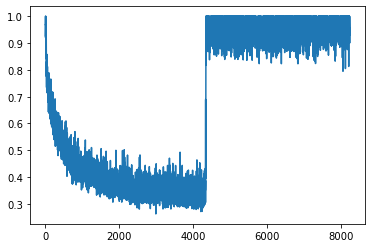

In [90]:
import matplotlib.pyplot as plt

RMSE_out = np.array(RMSE)
ones = np.ones((len(RMSE)))

RMSE_out = np.minimum(RMSE_out, ones)

plt.plot(RMSE_out)
plt.savefig('DNN-RMSE.png')